!pip install pandas-datareader

!pip install PyPortfolioOpt

!pip install plotly

In [3]:
from pandas_datareader.data import DataReader
import yfinance as yf
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
import copy
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

## Get Stock Prices using pandas_datareader Library
Let's get some data for the stock tickers that we want to include in our portfolio. The pandas-datareader library provides a method to pull stock price data from the web and store it in a DataFrame. 

If you do not pass in the start and end dates, stock prices will be given for the full date range available. Note that the date range may be different for different stocks depending on when they were listed.

In [4]:
start_date = '2013-01-01' 
end_date = '2022-4-17'

tickers = ['MA', 'META', 'V', 'AMZN', 'JPM', 'BA']
#stocks_df = DataReader(tickers, 'yahoo', start = start_date, end = end_date)['Adj Close']
stocks_df = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
stocks_df.head()

[*********************100%***********************]  6 of 6 completed


AMZN         BA        JPM         MA       META          V
Date                                                                      
2013-01-02  12.8655  64.583839  33.328999  47.876865  28.000000  36.085693
2013-01-03  12.9240  64.919044  33.261829  47.945343  27.770000  36.113556
2013-01-04  12.9575  65.103416  33.851391  47.943481  28.760000  36.408520
2013-01-07  13.4230  63.796139  33.888706  48.774345  29.420000  36.668625
2013-01-08  13.3190  62.120159  33.955879  48.613804  29.059999  37.010014

## Plot Individual Stock Prices
The graph is plotted with plotly library. It is an interactive graph.

In [5]:
fig_price = px.line(stocks_df, title='Price of Individual Stocks')
fig_price.show()

As seen above, Amazon seems to dominate the scale of the graph as the absolute price of the stock is very high. The graphs of all other stocks are flattened out. A graph like this is not very useful to compare the relative performance of the stocks. To address this, let's see how we can better measure the performance of a stock by exploring the concepts of daily returns and volatility.

## Daily Returns
The daily returns of a stock is the fractional gain (or loss) on a given day relative to the previous day, it is given by (current day's close price - previous day's close price) / (previous day's close price). As it is a relative value, it provides a fairer comparison between stock returns regardless of absolute stock prices. The pct_change() method can be used to get the daily returns efficiently.

In [6]:
daily_returns = stocks_df.pct_change().dropna()
daily_returns.head()

AMZN        BA       JPM        MA      META         V
Date                                                                  
2013-01-03  0.004547  0.005190 -0.002015  0.001430 -0.008214  0.000772
2013-01-04  0.002592  0.002840  0.017725 -0.000039  0.035650  0.008168
2013-01-07  0.035925 -0.020080  0.001102  0.017330  0.022949  0.007144
2013-01-08 -0.007748 -0.026271  0.001982 -0.003292 -0.012237  0.009310
2013-01-09 -0.000113  0.035478 -0.000659  0.028137  0.052650  0.015248

Let's plot out the daily returns of 2 of the stocks, Boeing (BA) and Visa (V), throughout the whole time period. We see that they tend to fluctuate gently around 0. Notably, the fluctuations are much greater during a period of high volatility (i.e. during the Covid crash in March 2020).

In [7]:
fig = px.line(daily_returns[['BA', 'V']], title='Daily Returns')
fig.show()

## Volatility

#### Daily Volatility

Daily Volatility is the average difference between the return on a given day and the average return over the time period. Mathematically, it is just the standard deviation of the daily returns. Volatility is one of the measures of risk in that highly volatile investments can carry greater risk.

In [8]:
daily_returns.std()

AMZN    0.019330
BA      0.023948
JPM     0.016772
MA      0.017019
META    0.022239
V       0.015621
dtype: float64

Here we see that BA has a slightly higher volatility, compared to that of V. When we compare the density plots of their daily returns, we can see that V has a narrower curve with a higher peak, while BA has a wider curve indicating higher standard deviation and hence volatility.

(-0.1, 0.1)

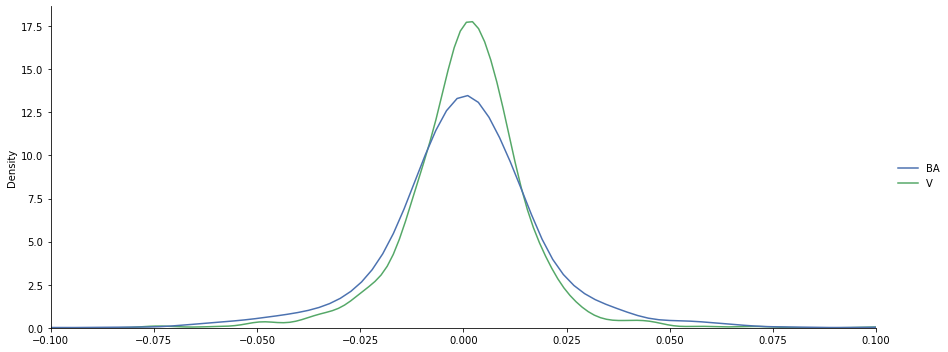

In [9]:
sns.displot(data=daily_returns[['BA', 'V']], kind = 'kde', aspect = 2.5)
plt.xlim(-0.1, 0.1)

#### Annual Volatility

For completeness, the Annual Volatility is a more common measure can be calculated simply by multiply the daily volatility by the square root of the number of trading days in a year i.e. 252. 

## Plot Individual Cumulative Returns
The cumulative returns of the stock can be easily calculated by adding one to the daily returns and taking the cumulative product over the whole period. Here we plot the cumulative returns of stocks starting with an initial investment of 100 (how much would investing 100 at the start in each individual stock get you over the time period?) This is a fair comparison for the performance of the stocks.

In [10]:
def plot_cum_returns(data, title):    
    daily_cum_returns = (1 + daily_returns).cumprod()*100
    fig = px.line(daily_cum_returns, title=title)
    return fig
    
fig_cum_returns = plot_cum_returns(stocks_df, 'Cumulative Returns of Individual Stocks Starting with $100')
fig_cum_returns.show()

## Plot Correlation Matrix between Stocks
The correlation matrix gives us the correlation coefficients between every pair of stocks. Correlation coefficients are indicators of the strength of the linear relationship between two different variables. It is a value from 0 to 1, with 1 indicating the strongest relationship. If it is a negative value, then the two variables are inversely related. 

In [11]:
corr_df = stocks_df.corr().round(2) # round to 2 decimal places
fig_corr = px.imshow(corr_df, text_auto=True, title = 'Correlation between Stocks')
fig_corr.show()


In general (though not always), stock prices tend to move together (increase in bull market, decrease in bear market), hence the correlation would most likely be positive as shown below. Also notice how Boeing (BA) is weakly correlated to other stocks during this time period. This may be because it is in a very different industry, or because of the bad news that has been hitting it over the recent years. And notice how Mastercard (MA) and Visa (V) are almost perfectly correlated.

## Get Expected Returns and Covariance Matrix
Similarly, the covariance matrix measures whether stocks move in the same direction (a positive covariance) or in opposite directions (a negative covariance). 
It is used to calculate the volatility of the whole portfolio of stocks, which in turn is used by portfolio managers to quantify its risk. PyPortfolioOpt makes it easy to get this matrix, and also the mean annual return of each stocks. We need these as inputs to find our optimized portfolio later.

In [12]:
# Calculate expected returns and sample covariance matrix
mu = expected_returns.mean_historical_return(stocks_df)
S = risk_models.sample_cov(stocks_df)

print(mu)

AMZN    0.304666
BA      0.118103
JPM     0.149305
MA      0.241052
META    0.242676
V       0.209486
dtype: float64


## Optimize portfolio for max Sharpe ratio plot it out with efficient frontier curve
The efficient frontier is the set of optimal portfolios that offer the highest expected return for a defined level of risk (volatility) or the lowest risk (volatility) for a given level of expected return. It is represented by a line on a Return vs Volatility graph. The max Sharpe ratio portfolio lies on the efficient frontier. 

To represent everything visually, the code below (from documentation) generates 1000 portfolios of our stocks with random weights and plot out their returns and volatility. The efficient frontier and the max Sharpe ratio portfolio is also plotted on the graph.

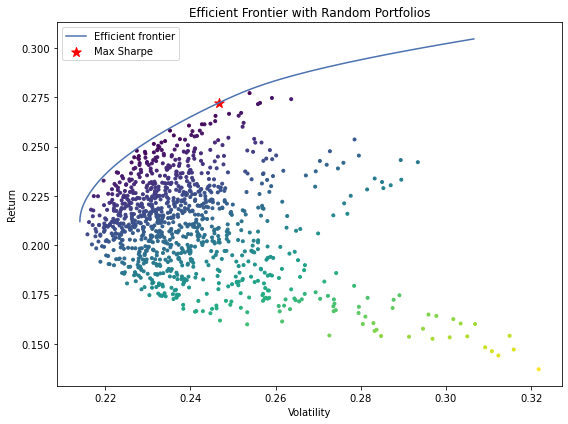

In [13]:
def plot_efficient_frontier_and_max_sharpe(mu, S):  
    # Optimize portfolio for maximal Sharpe ratio 
    ef = EfficientFrontier(mu, S)

    fig, ax = plt.subplots(figsize=(8,6))
    ef_max_sharpe = copy.deepcopy(ef)
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

    # Find the max sharpe portfolio
    ef_max_sharpe.max_sharpe(risk_free_rate=0.02)
    ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

    # Generate random portfolios
    n_samples = 1000
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

    # Output
    ax.set_title("Efficient Frontier with Random Portfolios")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
plot_efficient_frontier_and_max_sharpe(mu, S)

Hopefully the graph gives you a better idea of what the efficient frontier is. In the graph above, we see that the efficient frontier is like a boundary. i.e. It is not possible for portfolios to lie above the frontier (else we would have portfolios with the same volatility as those on the frontier but with higher expected returns). It is also not possible for portfolios to lie at the left of the frontier (else we would have portfolios with the same expected returns as those on the frontier but with lower volatility).

## Get Weights for Optimized Portfolio

In [14]:
ef = EfficientFrontier(mu, S)
ef.max_sharpe(risk_free_rate=0.02)
weights = ef.clean_weights()
print(weights)

OrderedDict([('AMZN', 0.52723), ('BA', 0.0), ('JPM', 0.0), ('MA', 0.35911), ('META', 0.03502), ('V', 0.07864)])


In [15]:
weights_df = pd.DataFrame.from_dict(weights, orient = 'index')
weights_df.columns = ['weights']
weights_df

weights
AMZN  0.52723
BA    0.00000
JPM   0.00000
MA    0.35911
META  0.03502
V     0.07864

Notice how certain weights tend to dominate by high performing stocks (high returns with relatively ok volatility), while some weights tend to be 0. One of the weakness of the max Sharpe portfolio optimization approach is that the portfolio may not be as diversified (across types of stocks or industries) as we want it to be. Also, as cliche as it may sound, past performance is not indicative of future results. We are obtaining the expected returns and volatility based on the movement of stock prices in the past, the future returns/volatility may very well differ.

## Expected Annual Return, Annual Volatility and Sharpe Ratio for Optimized Portfolio

In [16]:
expected_annual_return, annual_volatility, sharpe_ratio = ef.portfolio_performance()

print('Expected annual return: {}%'.format((expected_annual_return*100).round(2)))
print('Annual volatility: {}%'.format((annual_volatility*100).round(2)))
print('Sharpe ratio: {}'.format(sharpe_ratio.round(2)))

Expected annual return: 27.22%
Annual volatility: 24.67%
Sharpe ratio: 1.02


## Generate Portfolio with Optimized Weights

In [17]:
stocks_df['Optimized Portfolio'] = 0

for ticker, weight in weights.items():
    stocks_df['Optimized Portfolio'] += stocks_df[ticker]*weight

stocks_df.head()

AMZN         BA        JPM         MA       META          V  \
Date                                                                         
2013-01-02  12.8655  64.583839  33.328999  47.876865  28.000000  36.085693   
2013-01-03  12.9240  64.919044  33.261829  47.945343  27.770000  36.113556   
2013-01-04  12.9575  65.103416  33.851391  47.943481  28.760000  36.408520   
2013-01-07  13.4230  63.796139  33.888706  48.774345  29.420000  36.668625   
2013-01-08  13.3190  62.120159  33.955879  48.613804  29.059999  37.010014   

            Optimized Portfolio  
Date                             
2013-01-02            27.794478  
2013-01-03            27.844048  
2013-01-04            27.918908  
2013-01-07            28.506273  
2013-01-08            28.408028

## Plot Cumulative Returns of Optimized Portfolio

In [18]:
fig_cum_returns_optimized = plot_cum_returns(stocks_df['Optimized Portfolio'], 'Cumulative Returns of Optimized Portfolio Starting with $100')
fig_cum_returns_optimized.show()